# Optimization

This is the final step of the flood assessment. Optimization strives  to optimise the opportunities to minimise the KPIs so that the damage, expressed in both human lives and costs, is limited. The robust optimization method Multi-Objective Robust Optimization (MORO) is used to determine the desired policy. This method considers a set of scenarios and optimises the robustness of strategies over a specific set of scenarios.

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import functools

from ema_workbench import ema_logging, MultiprocessingEvaluator, SequentialEvaluator, Samplers
from ema_workbench import ScalarOutcome

from problem_formulation import get_model_for_problem_formulation

dike_model, _= get_model_for_problem_formulation(3)

In [2]:
# Open file with outcomes

outcomes = pd.read_csv('./open_exploration/outcomes_3.csv', index_col=None)
outcomes.head()

,Unnamed: 0,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0,2.018911e+08,0.0,1.449938e+08,0.000547,1.034037e+08,0.00000,4.961730e+07,0.0,1.420865e+08,0.0,916200000.0,251.360364
1,1,2.018911e+08,0.0,1.473542e+08,0.000540,1.034037e+08,0.00000,4.961730e+07,0.0,1.420865e+08,0.0,916200000.0,250.206239
2,2,2.018911e+08,0.0,1.458849e+08,0.000528,1.034037e+08,0.00000,4.961730e+07,0.0,1.420865e+08,0.0,916200000.0,248.209112
3,3,2.018911e+08,0.0,1.442790e+08,0.000538,1.979968e+08,0.02345,4.961730e+07,0.0,1.420865e+08,0.0,916200000.0,5871.138688
4,4,2.018911e+08,0.0,2.107146e+08,0.007240,1.034037e+08,0.00000,4.961730e+07,0.0,1.420865e+08,0.0,916200000.0,3771.253650


In [3]:
# Open file with experiments

experiments = pd.read_csv('./open_exploration/experiments_3.csv', index_col=None)
experiments.head()

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,0,3,119.122289,1.5,0.591532,98.631919,1.5,0.685550,164.891327,1.0,...,3,7,9,8,4,4,3,2600,2500,dikesnet
1,1,11,346.165771,1.5,0.302154,246.604741,1.5,0.496800,37.053241,1.0,...,3,7,9,8,4,4,3,2601,2500,dikesnet
2,2,94,199.130213,1.5,0.425568,294.793947,1.0,0.589527,236.443753,10.0,...,3,7,9,8,4,4,3,2602,2500,dikesnet
3,3,55,219.662036,1.5,0.178258,318.247471,1.0,0.601927,110.599975,1.5,...,3,7,9,8,4,4,3,2603,2500,dikesnet
4,4,97,324.644018,10.0,0.326461,224.554061,1.0,0.107261,313.646632,1.0,...,3,7,9,8,4,4,3,2604,2500,dikesnet


In [4]:
experiments = experiments.drop(experiments.columns[[0]], axis = 1)
outcomes = outcomes.drop(outcomes.columns[[0]], axis = 1)

In [5]:
# Create a new column that combines all total costs/total deaths from all locations

outcomes['Total Costs'] = outcomes['A.1 Total Costs'] + outcomes['A.2 Total Costs'] + outcomes['A.3 Total Costs'] + outcomes['A.4 Total Costs'] + outcomes['A.5 Total Costs']
outcomes['Total Deaths'] = outcomes['A.1_Expected Number of Deaths'] + outcomes['A.2_Expected Number of Deaths'] + outcomes['A.3_Expected Number of Deaths'] + outcomes['A.4_Expected Number of Deaths'] + outcomes['A.5_Expected Number of Deaths']


## MORO

In [6]:
# Create robustness function that evaluates whether an outcome is within thresholds

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def totdeaths(data):
    return np.sum(data<=0.005)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

# Set max thresholds

totdeaths = functools.partial(robustness, SMALLER, 0.005)
totcosts = functools.partial(robustness, SMALLER, 0.75e9)
rfrtotcosts = functools.partial(robustness, SMALLER, 1.25e9)

In [11]:
# Specify specific outcomes

outcomes = outcomes[['Total Costs', 'Total Deaths', "RfR Total Costs"]]

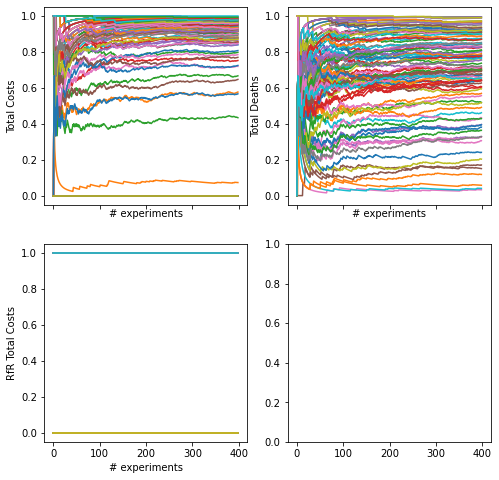

In [12]:
# Determine how many experiments (scenarios) are needed when KPIs converge

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

robustness_funcs = {"Total Deaths": totdeaths,
                    "Total Costs": totcosts,
                    "RfR Total Costs": rfrtotcosts}

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

In [20]:
# Set up scenarios

from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 5 #needs to be made more, but 5 for testing
scenarios = sample_uncertainties(dike_model, n_scenarios)

In [28]:
# Define epsilon values for MORO

epsilon_fraction = 10
KPI_max_list = [totcosts, totdeaths, rfrtotcosts]
print(f"Max KPI preferred: {KPI_max_list}")

epsilons = [i/epsilon_fraction for i in KPI_max_list]
print(f"Epsilon values: {epsilons}")

Max KPI preferred: [750000000.0, 0.005, 1250000000.0]
Epsilon values: [75000000.0, 0.0005, 125000000.0]


In [29]:
# Define convergence, outcome direction and robustness function

from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume

convergence = [EpsilonProgress()]

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Total Costs': total_costs,
         'Total Deaths': deaths,
         'RfR Total Costs': rfrcosts}

robustnes_functions = [ScalarOutcome('Total Costs', kind=MINIMIZE,
                                     function=totcosts),
                       ScalarOutcome('Total Deaths', kind=MINIMIZE,
                                     function=totdeaths),
                       ScalarOutcome('RfR Total Costs', kind=MINIMIZE,
                                     function=rfrtotcosts),
                      ]


In [ ]:
# Run MORO 

with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe, convergence=convergence, epsilons=epsilons, convergence_freq=25, logging_freq=1)
        
archive, convergence = results

In [ ]:
# Save MORO results

archives.to_csv('MORO_archives.csv')
convergence = pd.DataFrame.from_dict(convergence)
convergence.to_csv('MORO_convergence.csv')

In [ ]:
# Visualise MORO results

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()